### Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

# 1. Example match
Data taken from https://www.oddsportal.com/basketball/usa/nba/houston-rockets-golden-state-warriors-lMlLpR7P/

In [2]:
df_example = pd.read_csv("data/example_basketball_game.csv", index_col=0)
df_example['Time'] = pd.to_datetime(df_example['Time'])
df_example = df_example.rename(columns={"Type": "Team name"})
df_example.head()

,Time,Book_n,Coef,Team name
0,2018-11-16 01:39:00,10Bet,1.59,home
1,2018-11-15 20:06:00,10Bet,1.63,home
2,2018-11-15 19:15:00,10Bet,1.67,home
3,2018-11-15 18:06:00,10Bet,1.65,home
4,2018-11-15 16:03:00,10Bet,1.73,home


### 1.1 Plot coeficient temporal dependance

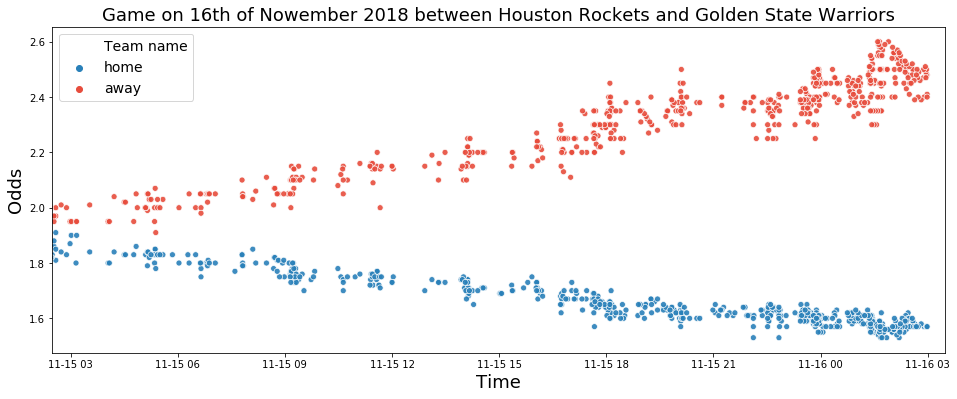

In [3]:
x_min = df_example.Time.max() - datetime.timedelta(hours=24.5)
x_max = df_example.Time.max() + datetime.timedelta(hours=0.5)
plt.figure(figsize=(16, 6))
ax = sns.scatterplot(x="Time", y="Coef", hue="Team name", data=df_example,
                     palette=dict(home="#2980b9", away="#e74c3c"), alpha=0.9)
ax.set_title("Game on 16th of Nowember 2018 between Houston Rockets and Golden State Warriors",
            fontsize=18)
ax.set_ylabel("Odds",fontsize=18)
ax.set_xlabel("Time", fontsize=18)
ax.set_xlim(x_min, x_max)
plt.legend(fontsize=14)
plt.savefig("images/example_game_time.png", dpi=200, format="png", bbox_inches="tight");

### 1.2 Plot histogram of last available coeficients 

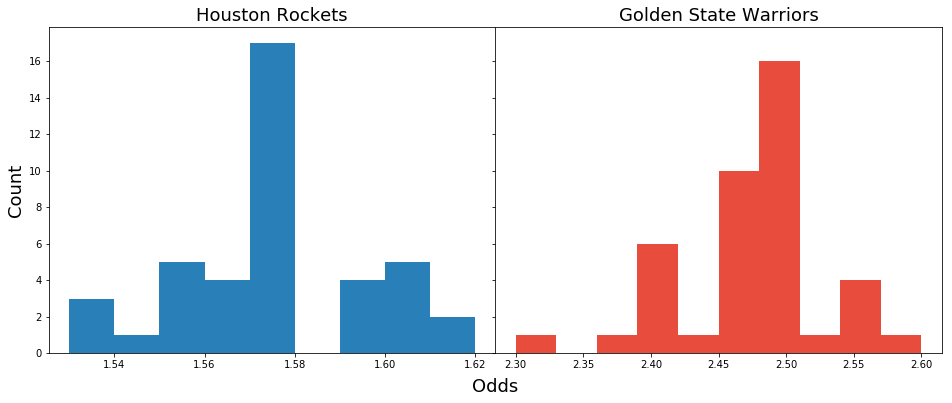

In [4]:
# process results
home_last = df_example[df_example["Team name"]=="home"].groupby('Book_n')["Coef"].first()
away_last = df_example[df_example["Team name"]=="away"].groupby('Book_n')["Coef"].first()
# plot results
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,6))
ax1.hist(home_last.values, bins=9, color="#2980b9")
ax1.set_ylabel("Count", fontsize=18)
ax1.set_title("Houston Rockets", fontsize=18)
ax2.hist(away_last.values, bins=10, color="#e74c3c")
ax2.set_title("Golden State Warriors", fontsize=18)
f.subplots_adjust(wspace=0)
ax2.set_xlabel("Odds", fontsize=18);
ax2.xaxis.set_label_coords(0, -0.075);
plt.savefig("images/example_game_last_coeff.png", dpi=200, format="png", bbox_inches="tight");

# 2. Data preparation
Due to complicated data scraping procedure (website was rendered in Javascript), data is located in many different .csv files. This section is used to clean and preparare data for further analysis.Main objectives:
* Load all data into DataFrames,
* Check for NAN values (drop NAN rows if needed),
* Check for duplicates,
* Concactinate everything into single DataFrame.

### 2.1 Game outcomes
File `basketball_games.csv` contains infomration about NBA and Euroleague games. Each column coresponds to:
* League name,
* Season match was played on,
* Away team final score,
* Home team final score,
* Who won (1.0- Home team won, 0.0- Away Team won),
* Did game require overtime (OT)? (1.0- Yes, 0.0- No),
* Highest avaibable coeficient for Home win prior to match start,
* Highest avaibable coeficient for Away win prior to match start,
* Link to detailed information about the match. URL link is unique for each match.

In [5]:
df_scores = pd.read_csv("data/basketball_games.csv", index_col=0)
df_scores.head()

,League,Season,Home_score,Away_score,Win,OT,Home_p,Away_p,URL
0,NBA,2017/2018,85.0,108.0,0.0,0.0,2.55,1.68,https://www.oddsportal.com/basketball/usa/nba-...
1,NBA,2017/2018,102.0,110.0,0.0,0.0,2.35,1.75,https://www.oddsportal.com/basketball/usa/nba-...
2,NBA,2017/2018,122.0,103.0,1.0,0.0,1.23,5.80,https://www.oddsportal.com/basketball/usa/nba-...
3,NBA,2017/2018,124.0,114.0,1.0,1.0,1.14,8.16,https://www.oddsportal.com/basketball/usa/nba-...
4,NBA,2017/2018,92.0,101.0,0.0,0.0,3.50,1.40,https://www.oddsportal.com/basketball/usa/nba-...


In [6]:
# check for NAN values
df_scores.isna().sum()

League        0
Season        0
Home_score    1
Away_score    1
Win           1
OT            1
Home_p        0
Away_p        0
URL           0
dtype: int64

In [7]:
# Make sure there are no duplicate entries
print("original data has {} entries".format(df_scores.shape[0]))
df_scores = df_scores.drop_duplicates(subset='URL', keep="first")
print("after droping duplicates {} entries left".format(df_scores.shape[0]))
# Drop missing values
df_scores = df_scores.dropna()
print("after droping NAN values {} entries left".format(df_scores.shape[0]))

original data has 8345 entries
after droping duplicates 8345 entries left
after droping NAN values 8344 entries left


In [8]:
# Calculate total points cored per match
df_scores['Total'] = df_scores["Away_score"] + df_scores["Home_score"]
# Change data type from float to integer
df_scores["Win"] = df_scores["Win"].astype(int)
df_scores["OT"] = df_scores["OT"].astype(int)

In [9]:
# check how many entries per league per season there are
df_scores.groupby(["League", "Season"])["URL"].count()

League  Season   
EURO    2013/2014     260
        2014/2015     258
        2015/2016     250
        2016/2017     259
        2017/2018     260
NBA     2013/2014    1428
        2014/2015    1419
        2015/2016    1418
        2016/2017    1408
        2017/2018    1384
Name: URL, dtype: int64

### 2.2 Detailed market coefficient information
Files `NBA_201X_201Y.csv` and `EURO_201X_201Y.csv` contains detailed information about market prices. Each column coresponds to:
* Asian Handicap (AH), calculated to home team, e.g. +3.5 means that after match is over, 3.5 points are added to home team score and only then match winner is decided,
* Coefficient for AH bet on Home team,
* Coefficient for AH bet on Away team,
* Over/Under (OU) value. Bet is won if total score is above (over) or bellow (under) the OU value. If OU is whole number, e.g. 157, and total points scored is equal to OU, bet is voided (money is returned to betor),
* Over coefficient value,
* Under coefficient value,
* Home team name,
* Away team name,
* Date and hour match started,
* Link to detailed information about the match. URL link is unique for each match.

In [10]:
filenames = ["EURO_2014_2015.csv", "EURO_2015_2016.csv", "EURO_2016_2017.csv", "EURO_2017_2018.csv",
            "NBA_2013_2014.csv", "NBA_2014_2015.csv", "NBA_2015_2016.csv", "NBA_2016_2017.csv",
            "NBA_2017_2018.csv"]
df_detailed = pd.read_csv("data/EURO_2013_2014.csv", index_col=0)
for fname in filenames:
    df_detailed = pd.concat([df_detailed, pd.read_csv("data/"+fname, index_col=0)], ignore_index=True)

df_detailed.head()

,AH,AH_Home,AH_Away,OU,Over,Under,Home_name,Away_name,Date,URL
0,Asian handicap -10.5,1.95,2.12,Over/Under +157.5,2.02,2.06,Real Madrid,Maccabi Tel Aviv,"Sunday, 18 May 2014, 21:00",https://www.oddsportal.com/basketball/europe/e...
1,Asian handicap -2.5,1.98,2.02,Over/Under +151.5,2.05,1.95,Barcelona,CSKA Moscow,"Sunday, 18 May 2014, 18:00",https://www.oddsportal.com/basketball/europe/e...
2,Asian handicap +2.5,1.95,2.20,Over/Under +155.5,2.10,1.97,Barcelona,Real Madrid,"Friday, 16 May 2014, 22:00",https://www.oddsportal.com/basketball/europe/e...
3,Asian handicap -6.5,1.95,2.08,Over/Under +147.5,2.06,1.95,CSKA Moscow,Maccabi Tel Aviv,"Friday, 16 May 2014, 19:00",https://www.oddsportal.com/basketball/europe/e...
4,Asian handicap -8.5,2.03,1.95,Over/Under +153.5,2.01,1.91,Real Madrid,Olympiakos,"Friday, 25 Apr 2014, 21:45",https://www.oddsportal.com/basketball/europe/e...


In [11]:
# check for dublicate entries
print("original data has {} entries".format(df_detailed.shape[0]))
df_detailed = df_detailed.drop_duplicates(subset='URL', keep="first")
print("after removing duplicates {} entries left".format(df_detailed.shape[0]))
# Drop missing values
df_detailed = df_detailed.dropna()
print("after removign NAN values {} entries left".format(df_detailed.shape[0]))

original data has 8345 entries
after removing duplicates 8345 entries left
after removign NAN values 8320 entries left


In [12]:
def convert_OU(s):
    """
    Input:
        s: string, e.g. "Over/Under +157.5"
    Output:
        float, 157.5
    """
    try:
        return float(s[12:-1])
    except:
        return np.nan
    
def convert_AH(s):
    """
    Input:
        s: string, e.g. "Over/Under +157.5"
    Output:
        float, 157.5
    """
    try:
        return float(s[15:-1])
    except:
        return np.nan

# convert Over/Under and Asian Handicaps bet types to floats
df_detailed["OU"] = df_detailed["OU"].astype("str").apply(convert_OU)
df_detailed["AH"] = df_detailed["AH"].astype("str").apply(convert_AH)
df_detailed.head()

,AH,AH_Home,AH_Away,OU,Over,Under,Home_name,Away_name,Date,URL
0,-10.5,1.95,2.12,157.5,2.02,2.06,Real Madrid,Maccabi Tel Aviv,"Sunday, 18 May 2014, 21:00",https://www.oddsportal.com/basketball/europe/e...
1,-2.5,1.98,2.02,151.5,2.05,1.95,Barcelona,CSKA Moscow,"Sunday, 18 May 2014, 18:00",https://www.oddsportal.com/basketball/europe/e...
2,2.5,1.95,2.20,155.5,2.10,1.97,Barcelona,Real Madrid,"Friday, 16 May 2014, 22:00",https://www.oddsportal.com/basketball/europe/e...
3,-6.5,1.95,2.08,147.5,2.06,1.95,CSKA Moscow,Maccabi Tel Aviv,"Friday, 16 May 2014, 19:00",https://www.oddsportal.com/basketball/europe/e...
4,-8.5,2.03,1.95,153.5,2.01,1.91,Real Madrid,Olympiakos,"Friday, 25 Apr 2014, 21:45",https://www.oddsportal.com/basketball/europe/e...


In [13]:
# Convert Date to datetime elemnt
df_detailed["Date"] = pd.to_datetime(df_detailed['Date'], format='%A, %d %b %Y, %H:%M')
df_detailed.head()

,AH,AH_Home,AH_Away,OU,Over,Under,Home_name,Away_name,Date,URL
0,-10.5,1.95,2.12,157.5,2.02,2.06,Real Madrid,Maccabi Tel Aviv,2014-05-18 21:00:00,https://www.oddsportal.com/basketball/europe/e...
1,-2.5,1.98,2.02,151.5,2.05,1.95,Barcelona,CSKA Moscow,2014-05-18 18:00:00,https://www.oddsportal.com/basketball/europe/e...
2,2.5,1.95,2.20,155.5,2.10,1.97,Barcelona,Real Madrid,2014-05-16 22:00:00,https://www.oddsportal.com/basketball/europe/e...
3,-6.5,1.95,2.08,147.5,2.06,1.95,CSKA Moscow,Maccabi Tel Aviv,2014-05-16 19:00:00,https://www.oddsportal.com/basketball/europe/e...
4,-8.5,2.03,1.95,153.5,2.01,1.91,Real Madrid,Olympiakos,2014-04-25 21:45:00,https://www.oddsportal.com/basketball/europe/e...


### 2.3 Combine everything into one DataFrame

In [14]:
df = pd.merge(df_detailed, df_scores, on='URL', how='inner')
# check how many entries per League season is left after cleaning data
df.groupby(["League", "Season"])["URL"].count()

League  Season   
EURO    2013/2014     258
        2014/2015     255
        2015/2016     250
        2016/2017     259
        2017/2018     257
NBA     2013/2014    1426
        2014/2015    1410
        2015/2016    1418
        2016/2017    1408
        2017/2018    1378
Name: URL, dtype: int64

In [15]:
# check how much data was lost due to data scraping and processing processing
print("Missing data entries per League per Season after data wrangling")
df_scores.groupby(["League", "Season"])["URL"].count() - df.groupby(["League", "Season"])["URL"].count()

Missing data entries per League per Season after data wrangling


League  Season   
EURO    2013/2014    2
        2014/2015    3
        2015/2016    0
        2016/2017    0
        2017/2018    3
NBA     2013/2014    2
        2014/2015    9
        2015/2016    0
        2016/2017    0
        2017/2018    6
Name: URL, dtype: int64

Information was not gathered only on 25 matches , i.e. only 0.3 % of all data was missing.

### 2.4 Create DataFrame for all posible bets

Each row of `df_scores` DataFrame contains information about 3 bets (6 posible outcomes), head to head (home or away team win), asian handicap (home or away team win) and totals (under or over X amount of points). 

In [17]:
%%time
_data = list()
for idx in df.index:
    # get head to head (H2H) bets
    
    # calculate total implied probability for home/away bet
    implied_prop = 1/df.iloc[idx]["Home_p"] + 1/df.iloc[idx]["Away_p"]
    if df.iloc[idx]["Home_score"] > df.iloc[idx]["Away_score"]:
        _data.append(["H2H", "Home", df.iloc[idx]["Home_p"],
                      df.iloc[idx]["Home_p"]-1, implied_prop, df.iloc[idx]["URL"], 1])
        _data.append(["H2H", "Away", df.iloc[idx]["Away_p"],
                      -1, implied_prop, df.iloc[idx]["URL"], 0])
    else:
        _data.append(["H2H", "Home", df.iloc[idx]["Home_p"],
                      -1, implied_prop, df.iloc[idx]["URL"], 0])
        _data.append(["H2H", "Away", df.iloc[idx]["Away_p"],
                      df.iloc[idx]["Away_p"]-1, implied_prop, df.iloc[idx]["URL"], 1])
    
    # get Asian Handicap bets
    
    # calculate total implied probability for asian handicap bet
    implied_prop = 1/df.iloc[idx]["AH_Home"] + 1/df.iloc[idx]["AH_Away"]
    if df.iloc[idx]["Home_score"] + df.iloc[idx]["AH"] > df.iloc[idx]["Away_score"]:
        _data.append(["AH", "Home", df.iloc[idx]["AH_Home"], df.iloc[idx]["AH_Home"]-1, df.iloc[idx]["URL"], 1])
        _data.append(["AH", "Away", df.iloc[idx]["AH_Away"], -1, df.iloc[idx]["URL"], 0])
    elif df.iloc[idx]["Home_score"] + df.iloc[idx]["AH"] < df.iloc[idx]["Away_score"]:
        _data.append(["AH", "Home"+str(df.iloc[idx]["AH"]), df.iloc[idx]["AH_Home"],
                      -1, implied_prop, df.iloc[idx]["URL"], 0])
        _data.append(["AH", "Away"+str(df.iloc[idx]["AH"]), df.iloc[idx]["AH_Away"],
                      df.iloc[idx]["AH_Away"]-1, implied_prop, df.iloc[idx]["URL"], 1])
    # bet is voided
    else:
        _data.append(["AH", "Home"+str(df.iloc[idx]["AH"]),  df.iloc[idx]["AH_Home"],
                      0, implied_prop, df.iloc[idx]["URL"], np.nan])
        _data.append(["AH", "Away"+str(df.iloc[idx]["AH"]), df.iloc[idx]["AH_Away"],
                      0, implied_prop, df.iloc[idx]["URL"], np.nan])
        
    # get Over/Under bets, but only from matches without overtime (OT)
    
    # calculate total implied probability for over/under bet
    implied_prop = 1/df.iloc[idx]["Over"] + 1/df.iloc[idx]["Under"]
    if df.iloc[idx]["OT"] == 0:
        if df.iloc[idx]["Total"] >  df.iloc[idx]["OU"]:
            _data.append(["OU", "Over"+str(df.iloc[idx]["Total"]),
                          df.iloc[idx]["Over"], df.iloc[idx]["Over"]-1, implied_prop, df.iloc[idx]["URL"], 1])
            _data.append(["OU", "Under"+str(df.iloc[idx]["Total"]),
                          df.iloc[idx]["Under"], -1, implied_prop, df.iloc[idx]["URL"], 0])
        elif df.iloc[idx]["Total"] >  df.iloc[idx]["OU"]:
            _data.append(["OU", "Over"+str(df.iloc[idx]["Total"]),
                          df.iloc[idx]["Over"], -1, implied_prop, df.iloc[idx]["URL"], 0])
            _data.append(["OU", "Under"+str(df.iloc[idx]["Total"]),
                          df.iloc[idx]["Under"], df.iloc[idx]["Over"]-1, implied_prop, df.iloc[idx]["URL"], 1])
        # bet is voided
        else:
            _data.append(["OU", "Over"+str(df.iloc[idx]["Total"]),
                          df.iloc[idx]["Over"], 0, implied_prop, df.iloc[idx]["URL"], np.nan])
            _data.append(["OU", "Under"+str(df.iloc[idx]["Total"]),
                          df.iloc[idx]["Under"], 0, implied_prop, df.iloc[idx]["URL"], np.nan])  

Wall time: 1min 33s


In [18]:
# create new DataFrame for all bets
df_bets = pd.DataFrame(_data,
                       columns=["Bet type", "Bet subtype", "Odds", "Net outcome",
                                "Total implied probability", "URL", "Bet outcome"])  

# round to float 2 precision to avoid Python float precision issues
df_bets["Implied probability"] = round(1.0/df_bets["Odds"], 2)
df_bets.head()

,Bet type,Bet subtype,Odds,Net outcome,Total implied probability,URL,Bet outcome,Implied probability
0,H2H,Home,1.18,-1.00,0.995606,https://www.oddsportal.com/basketball/europe/e...,0.0,0.85
1,H2H,Away,6.75,5.75,0.995606,https://www.oddsportal.com/basketball/europe/e...,1.0,0.15
2,AH,Home-10.5,1.95,-1.00,0.984519,https://www.oddsportal.com/basketball/europe/e...,0.0,0.51
3,AH,Away-10.5,2.12,1.12,0.984519,https://www.oddsportal.com/basketball/europe/e...,1.0,0.47
4,H2H,Home,1.82,0.82,0.991928,https://www.oddsportal.com/basketball/europe/e...,1.0,0.55


In [19]:
# add information about match, team names, league and season.
df_bets = pd.merge(df_bets, df[["Home_name", "Away_name", "Date", "League", "Season","URL"]],
                   on='URL', how='inner')
df_bets.head()

,Bet type,Bet subtype,Odds,Net outcome,Total implied probability,URL,Bet outcome,Implied probability,Home_name,Away_name,Date,League,Season
0,H2H,Home,1.18,-1.00,0.995606,https://www.oddsportal.com/basketball/europe/e...,0.0,0.85,Real Madrid,Maccabi Tel Aviv,2014-05-18 21:00:00,EURO,2013/2014
1,H2H,Away,6.75,5.75,0.995606,https://www.oddsportal.com/basketball/europe/e...,1.0,0.15,Real Madrid,Maccabi Tel Aviv,2014-05-18 21:00:00,EURO,2013/2014
2,AH,Home-10.5,1.95,-1.00,0.984519,https://www.oddsportal.com/basketball/europe/e...,0.0,0.51,Real Madrid,Maccabi Tel Aviv,2014-05-18 21:00:00,EURO,2013/2014
3,AH,Away-10.5,2.12,1.12,0.984519,https://www.oddsportal.com/basketball/europe/e...,1.0,0.47,Real Madrid,Maccabi Tel Aviv,2014-05-18 21:00:00,EURO,2013/2014
4,H2H,Home,1.82,0.82,0.991928,https://www.oddsportal.com/basketball/europe/e...,1.0,0.55,Barcelona,CSKA Moscow,2014-05-18 18:00:00,EURO,2013/2014


## 3 Data analysis
### 3.1 Test NULL hypothesis

**NULL hypothesis**- betting randomly on Home/Away win, Asian Handicap or Over/Under markets is not profitable in long run. Return on investment (ROI) is negative or equal to 0.

In [24]:
average_implied_prop = df_bets["Total implied probability"].mean() * 100
print("Average total implied propability {:.2f} %".format(average_implied_prop))

Average total implied propability 100.14 %


### 3.1.1 All data

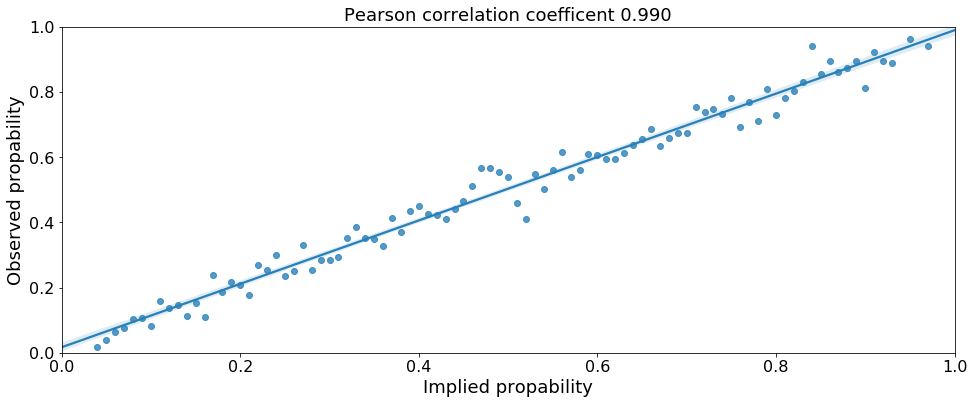

In [26]:
# group implied probabilities
_groupedby_object = df_bets.groupby(["Implied probability"])["Bet outcome"].mean()
_df = pd.DataFrame({'Observed probability': _groupedby_object}).reset_index()
# exclude outliers, data poitns with observed probability of 0 or 1
_df = _df[(_df["Observed probability"]<1) & (_df["Observed probability"]>0)]

# Calcualte Pearson coerelation cofficient
corr_coeff = _df["Implied probability"].corr(_df["Observed probability"]) 

# plot all data
plt.figure(figsize=(16, 6))
ax = sns.regplot(x="Implied probability", y="Observed probability", data=_df, color="#2980b9");
ax.set_title("Pearson correlation coefficent {:.3f}".format(corr_coeff), fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel("Implied propability", fontsize=18)
ax.set_ylabel("Observed propability", fontsize=18)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.savefig("images/observed_prob_vs_implied_all_data.png", dpi=200, format="png", bbox_inches="tight");

### 3.1.2 NULL hypothesis for each league
Test whatever NULL hypothesis holds true for both leagues by analyzing them sepreratly.

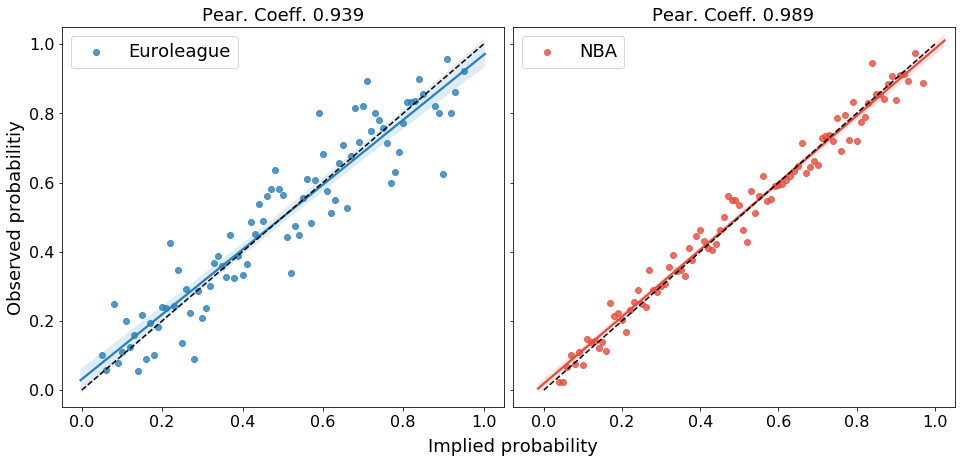

In [32]:
# group implied probabilities
_groupedby_object = df_bets.groupby(["League", "Implied probability"])["Bet outcome"].mean()
_df = pd.DataFrame({'Observed probability': _groupedby_object}).reset_index()
# exclude outliers, data poitns with observed probability of 0 or 1
_df = _df[(_df["Observed probability"]<1) & (_df["Observed probability"]>0)]

# plot results
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,7))
# Euroleague
_df_euro = _df[_df["League"]=="EURO"]
# Calculate Pearson coerelation cofficient for Euroleague
corr_coeff_euro = _df_euro["Implied probability"].corr(_df_euro["Observed probability"])
ax1.tick_params(axis='both', which='major', labelsize=16)
sns.regplot(x="Implied probability", y="Observed probability", label="Euroleague",
            data=_df_euro, color="#2980b9", ax=ax1)
ax1.plot([0,1], [0,1], "k--")
ax1.set_xlabel(None)
ax1.set_ylabel("Observed probabilitiy", fontsize=18)
ax1.set_xlim(-0.05, 1.05)
ax1.set_ylim(-0.05, 1.05)
ax1.legend(loc=0, fontsize=18)
ax1.set_title("Pear. Coeff. {:.3f}".format(corr_coeff_euro), fontsize=18)

# NBA
_df_nba = _df[_df["League"]=="NBA"]

# Calculate Pearson coerelation cofficient for NBA
corr_coeff_nba = _df_nba["Implied probability"].corr(_df_nba["Observed probability"]) 

sns.regplot(x="Implied probability", y="Observed probability", label="NBA",
            data=_df_nba, color="#e74c3c", ax=ax2)
ax2.set_xlabel("Implied probability", fontsize=18)
ax2.plot([0,1], [0,1], "k--")
ax2.set_ylabel(None)
ax2.set_xlim(-0.08, 1.05)
ax2.legend(loc=0, fontsize=18)
ax2.set_title("Pear. Coeff. {:.3f}".format(corr_coeff_nba), fontsize=18)

ax2.tick_params(axis='both', which='major', labelsize=16)

ax2.xaxis.set_label_coords(0, -0.08)
f.subplots_adjust(wspace=0.02)
plt.savefig("images/observed_prob_vs_implied_separate.png", dpi=200, format="png", bbox_inches="tight");

### 3.1.3 Make random sampling test

In [112]:
%%time
# study only bets which finished wihout arbitrage (total implied pobability >=1)
_df = df_bets[df_bets["Total implied probability"]>=1]
sim_results = dict()
for league in ["NBA", "EURO"]:
    # simulate 500 random from all 5 seasons for each League
    _data = list()
    for n in range(10000):
        bets_500 = _df[_df["League"]==league]["Net outcome"].sample(100, replace=False).sum()
        # append return of investment (net outcome divided by 500 number of unit bets and
        # multiplied by 100 to get procentages)
        _data.append(bets_500/5.0)
    sim_results[league] = _data

Wall time: 2min 48s


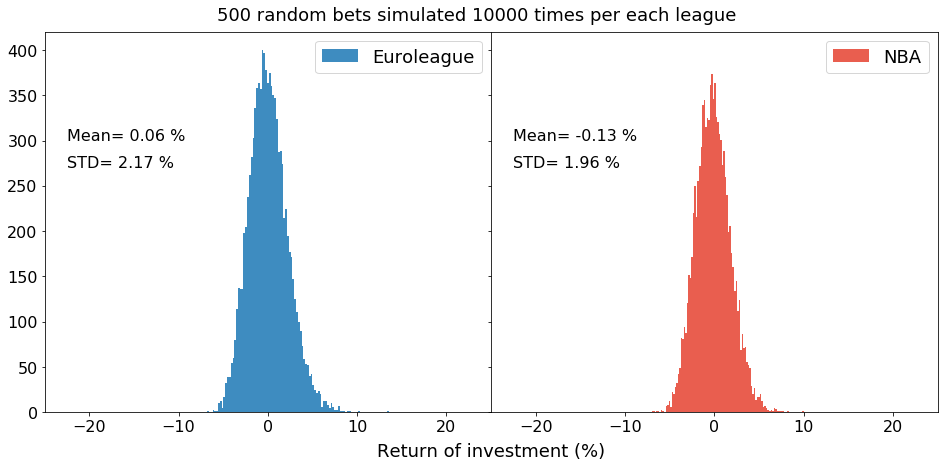

In [122]:
# plot results
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(16,7))
f.suptitle('500 random bets simulated 10000 times per each league', y=0.93, fontsize=18)

# Euroleague
ax1.hist(sim_results["EURO"], bins=100, label="Euroleague", color="#2980b9", alpha=0.9)
ax1.legend(loc=0, fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=16)
# calculate NBA ROI mean and std
mean_euro = np.mean(sim_results["EURO"])
std_euro = np.std(sim_results["EURO"])
ax1.text(-22.5, 300, "Mean= {:.2f} %".format(mean_euro), fontsize=16)
ax1.text(-22.5, 270, "STD= {:.2f} %".format(std_euro), fontsize=16)
ax1.set_xlim(-25, 25)

# NBA
ax2.hist(sim_results["NBA"], bins=100, label="NBA", color="#e74c3c", alpha=0.9)
ax2.legend(loc=0, fontsize=18)
# calculate NBA ROI mean and std
mean_nba = np.mean(sim_results["NBA"])
std_nba = np.std(sim_results["NBA"])
ax2.text(-22.5, 300, "Mean= {:.2f} %".format(mean_nba), fontsize=16)
ax2.text(-22.5, 270, "STD= {:.2f} %".format(std_nba), fontsize=16)
ax2.set_xlabel("Return of investment (%)", fontsize=18)
ax2.xaxis.set_label_coords(0, -0.08)
ax2.tick_params(axis='both', which='major', labelsize=16)
f.subplots_adjust(wspace=0.0)
plt.savefig("images/random_bet_simulations.png", dpi=200, format="png", bbox_inches="tight");

### Calculate confidence intervals alpha=99% for rejecting NULL hypothesis

In [124]:
euro_c1 = np.percentile(sim_results["EURO"], 0.5)
euro_c2 = np.percentile(sim_results["EURO"], 99.5)
nba_c1 = np.percentile(sim_results["NBA"], 0.5)
nba_c2 = np.percentile(sim_results["NBA"], 99.5)
print("Random betting 99% confidence intervals:")
print("Euroleague ({:.2f}, {:.2f})".format(euro_c1, euro_c2))
print("NBA ({:.2f}, {:.2f})".format(nba_c1, nba_c2))

Random betting 99% confidence intervals:
Euroleague (-4.77, 6.60)
NBA (-4.71, 5.42)


### 3.2 Totals betting market analysis
Totals- total points scored per game by both teams

### 3.2.1 total points score per game

In [100]:
# Total points per League per Season
df.groupby(["League", "Season"])["Total"].mean().round(2)

League  Season   
EURO    2013/2014    151.51
        2014/2015    155.80
        2015/2016    154.53
        2016/2017    158.17
        2017/2018    161.61
NBA     2013/2014    201.07
        2014/2015    200.05
        2015/2016    204.67
        2016/2017    210.88
        2017/2018    212.25
Name: Total, dtype: float64

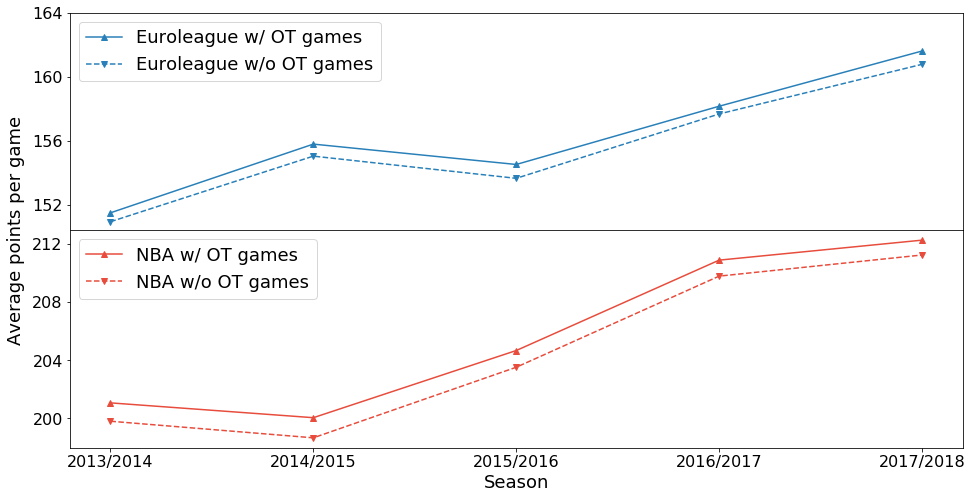

In [106]:
# split DataFrames into NBA and Euroleague DataFrames
df_euro = df[df.League == 'EURO']
df_nba = df[df.League == 'NBA']

# total scored points including games finished with overtime
total_euro = df_euro.groupby(['Season'])['Total'].mean()
total_nba = df_nba.groupby(['Season'])['Total'].mean()

# total scored points excluding games finished with overtime
total_ot_euro = df_euro[df_euro.OT!=1].groupby(['Season'])['Total'].mean()
total_ot_nba = df_nba[df_nba.OT!=1].groupby(['Season'])['Total'].mean()

# plot results
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(16,8))
# Euroleague
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.plot(total_euro.index, total_euro.values, "^-", color="#2980b9", label="Euroleague w/ OT games")
ax1.plot(total_ot_euro.index, total_ot_euro.values, "v--", color="#2980b9", label="Euroleague w/o OT games")
ax1.legend(fontsize=18)
ax1.set_yticks([152, 156, 160, 164])
# NBA
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.plot(total_nba.index, total_nba.values, "^-", color="#e74c3c", label="NBA w/ OT games")
ax2.plot(total_ot_nba.index, total_ot_nba.values, "v--", color="#e74c3c", label="NBA w/o OT games")
ax2.legend(fontsize=18)
ax2.set_yticks([200, 204, 208, 212])
ax2.set_xlabel("Season", fontsize=18)
ax2.set_ylabel("Average points per game", fontsize=18)
ax2.xaxis.set_label_coords(0.5, -0.12)
ax2.yaxis.set_label_coords(-0.05, 1.0)
f.subplots_adjust(hspace=0)
# Save figure
plt.savefig("images/total_points.png", dpi=200, format="png", bbox_inches="tight")

###  How Totals markets correlate with total points scored

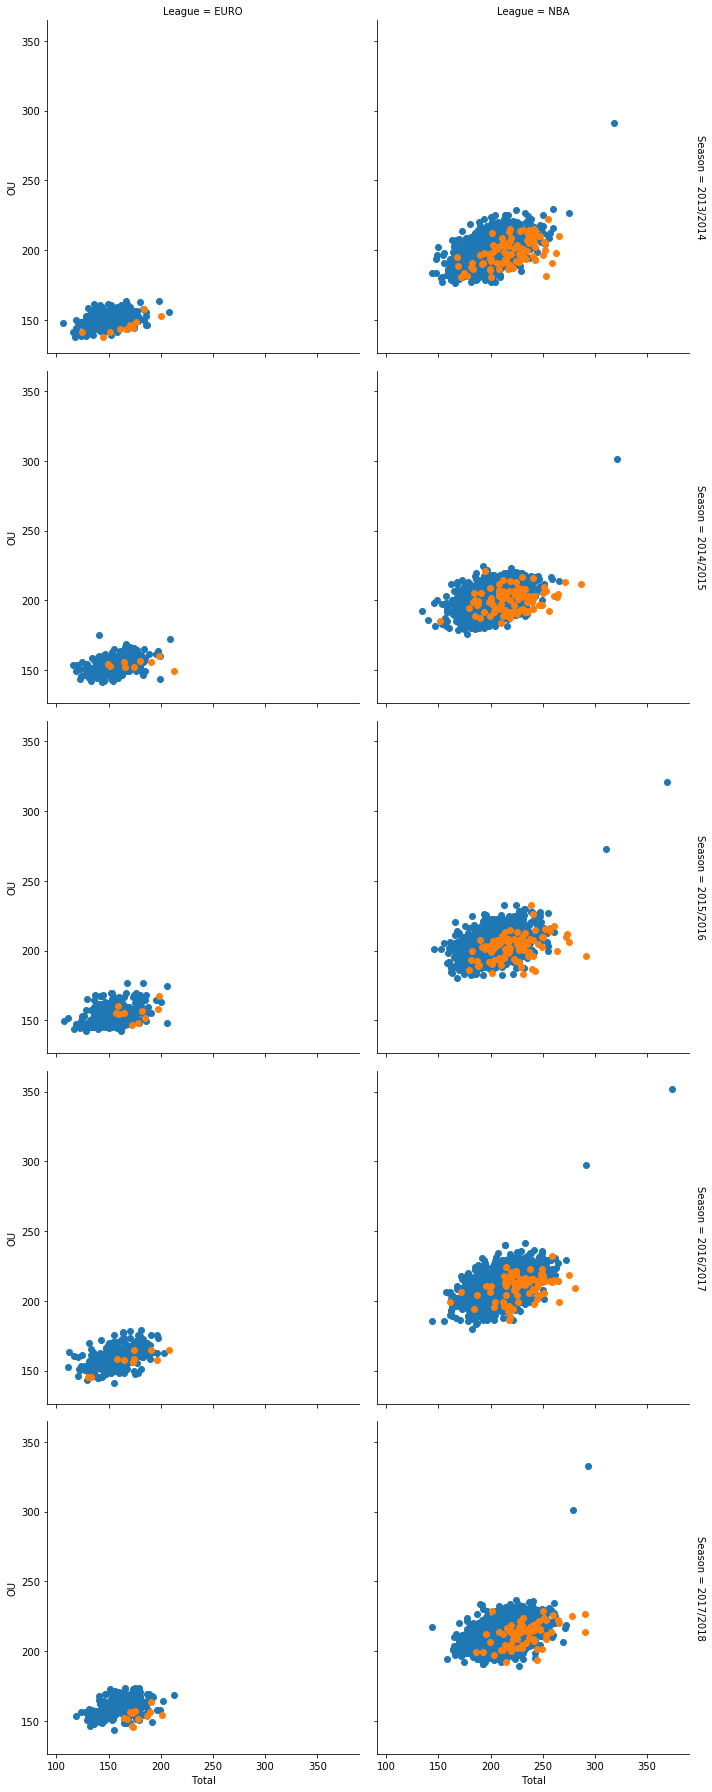

In [107]:
g = sns.FacetGrid(df, row="Season", col="League", hue="OT", margin_titles=True, height=5)
g.map(plt.scatter, "Total", "OU");

In [127]:
# investigate outliers
df[df.OU>250].sort_values("Date")[["Date", "Home_name", "Away_name", "OU", "Total"]]

,Date,Home_name,Away_name,OU,Total
1809,2014-02-17 03:00:00,East,West,291.0,318.0
3218,2015-02-16 03:30:00,East,West,301.5,321.0
4713,2016-02-13 04:00:00,Team World,Team USA,272.5,311.0
4712,2016-02-15 03:00:00,East,West,320.5,369.0
6081,2017-02-18 04:00:00,Team USA,Team World,297.5,291.0
6080,2017-02-20 03:00:00,West,East,352.0,374.0
7388,2018-02-17 04:00:00,Team USA,Team World,301.0,279.0
7387,2018-02-19 03:00:00,Team Stephen,Team LeBron,332.5,293.0


There are some special games during season when NBA players play for fun, hence many more points are scored during the match.

### Let's investigate whatever average scored points per month change over season

In [309]:
# make datetime DataFrame's index
_df = df_bets[df_bets["Bet type"] == "OU"].copy()
# create new collumn which tells whatever bet was on over
_df["Over"] = _df["Bet subtype"].apply(lambda x: True if x[:4]=="Over" else False)
# filter out under bets
_df = _df[(_df["Over"]==True) & (_df["Net outcome"]!=0)]
_df.head(10)

,Bet type,Bet subtype,Odds,Net outcome,Total implied probability,URL,Bet outcome,Implied probability,Home_name,Away_name,Date,League,Season,Over
6,OU,Over171.0,2.05,1.05,1.00063,https://www.oddsportal.com/basketball/europe/e...,1.0,0.49,Barcelona,CSKA Moscow,2014-05-18 18:00:00,EURO,2013/2014,True
12,OU,Over162.0,2.10,1.10,0.983805,https://www.oddsportal.com/basketball/europe/e...,1.0,0.48,Barcelona,Real Madrid,2014-05-16 22:00:00,EURO,2013/2014,True
54,OU,Over153.0,2.25,1.25,0.97076,https://www.oddsportal.com/basketball/europe/e...,1.0,0.44,Galatasaray,Barcelona,2014-04-20 20:00:00,EURO,2013/2014,True
58,OU,Over168.0,2.10,1.10,0.991654,https://www.oddsportal.com/basketball/europe/e...,1.0,0.48,Olimpia Milano,Maccabi Tel Aviv,2014-04-18 21:45:00,EURO,2013/2014,True
66,OU,Over147.0,2.05,1.05,1.01412,https://www.oddsportal.com/basketball/europe/e...,1.0,0.49,Barcelona,Galatasaray,2014-04-17 22:00:00,EURO,2013/2014,True
72,OU,Over159.0,2.02,1.02,0.992562,https://www.oddsportal.com/basketball/europe/e...,1.0,0.50,Real Madrid,Olympiakos,2014-04-17 20:00:00,EURO,2013/2014,True
84,OU,Over159.0,2.04,1.04,0.987709,https://www.oddsportal.com/basketball/europe/e...,1.0,0.49,Real Madrid,Olympiakos,2014-04-15 22:00:00,EURO,2013/2014,True
88,OU,Over149.0,2.00,1.00,1.0102,https://www.oddsportal.com/basketball/europe/e...,1.0,0.50,Barcelona,Galatasaray,2014-04-15 20:00:00,EURO,2013/2014,True
92,OU,Over180.0,2.10,1.10,0.991654,https://www.oddsportal.com/basketball/europe/e...,1.0,0.48,Unicaja,Olimpia Milano,2014-04-11 21:45:00,EURO,2013/2014,True
102,OU,Over167.0,1.96,0.96,1.01782,https://www.oddsportal.com/basketball/europe/e...,1.0,0.51,Zalgiris Kaunas,Real Madrid,2014-04-11 19:45:00,EURO,2013/2014,True


In [310]:
# make datetime DataFrame's index
_df = _df.set_index("Date")
# Create new DataFrame
net_returns = _df.groupby([pd.Grouper(freq='M'), "League", "Season"])["Net outcome"].mean()
_df = pd.DataFrame({"Monthly returns": net_returns}).reset_index()
# # add new month column
_df["Month"] = _df["Date"].dt.month
_df.head()

,Date,League,Season,Monthly returns,Month
0,2013-10-31,EURO,2013/2014,1.029474,10
1,2013-10-31,NBA,2013/2014,0.981321,10
2,2013-11-30,EURO,2013/2014,0.987600,11
3,2013-11-30,NBA,2013/2014,0.995761,11
4,2013-12-31,EURO,2013/2014,1.041875,12


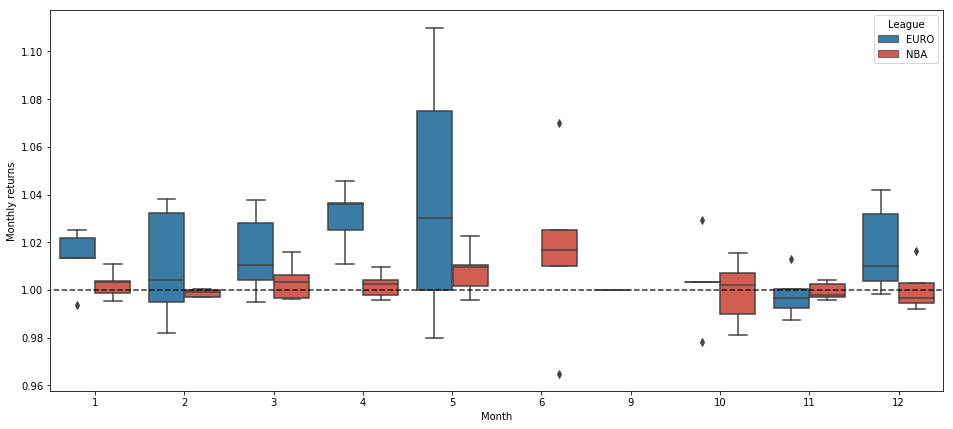

In [312]:
# plot results
f, ax1 = plt.subplots(figsize=(16,7))

# exclude semptember because of low amout of data
sns.boxplot(x="Month", y="Monthly returns", hue="League", data=_df, ax=ax1, palette=["#2980b9", "#e74c3c"])
ax1.plot([-1, 13], [1, 1], "k--", alpha=0.8);

In [303]:
net_returns["Net outcome"].mean()

Date        League  Season   
2013-10-31  EURO    2013/2014    1.029474
            NBA     2013/2014    0.981321
2013-11-30  EURO    2013/2014    0.987600
            NBA     2013/2014    0.995761
2013-12-31  EURO    2013/2014    1.041875
            NBA     2013/2014    1.016147
2014-01-31  EURO    2013/2014    1.025000
            NBA     2013/2014    1.010891
2014-02-28  EURO    2013/2014    0.981818
            NBA     2013/2014    0.997093
2014-03-31  EURO    2013/2014    1.037857
            NBA     2013/2014    0.996562
2014-04-30  EURO    2013/2014    1.036667
            NBA     2013/2014    1.009647
2014-05-31  EURO    2013/2014    1.075000
            NBA     2013/2014    1.009583
2014-06-30  NBA     2013/2014    1.010000
2014-09-30  EURO    2014/2015    1.000000
2014-10-31  EURO    2014/2015    1.003333
            NBA     2014/2015    0.990000
2014-11-30  EURO    2014/2015    0.992593
            NBA     2014/2015    1.002549
2014-12-31  EURO    2014/2015    0.998235
    

In [274]:
_df[_df["Net outcome"] == 0].shape[0] / _df.shape[0]

0.527501909854851

In [267]:
df.head()

,AH,AH_Home,AH_Away,OU,Over,Under,Home_name,Away_name,Date,URL,League,Season,Home_score,Away_score,Win,OT,Home_p,Away_p,Total
0,-10.5,1.95,2.12,157.5,2.02,2.06,Real Madrid,Maccabi Tel Aviv,2014-05-18 21:00:00,https://www.oddsportal.com/basketball/europe/e...,EURO,2013/2014,86.0,98.0,0,1,1.18,6.75,184.0
1,-2.5,1.98,2.02,151.5,2.05,1.95,Barcelona,CSKA Moscow,2014-05-18 18:00:00,https://www.oddsportal.com/basketball/europe/e...,EURO,2013/2014,93.0,78.0,1,0,1.82,2.26,171.0
2,2.5,1.95,2.20,155.5,2.10,1.97,Barcelona,Real Madrid,2014-05-16 22:00:00,https://www.oddsportal.com/basketball/europe/e...,EURO,2013/2014,62.0,100.0,0,0,2.58,1.70,162.0
3,-6.5,1.95,2.08,147.5,2.06,1.95,CSKA Moscow,Maccabi Tel Aviv,2014-05-16 19:00:00,https://www.oddsportal.com/basketball/europe/e...,EURO,2013/2014,67.0,68.0,0,0,1.40,3.60,135.0
4,-8.5,2.03,1.95,153.5,2.01,1.91,Real Madrid,Olympiakos,2014-04-25 21:45:00,https://www.oddsportal.com/basketball/europe/e...,EURO,2013/2014,83.0,69.0,1,0,1.27,5.70,152.0


In [270]:
# _df.join(df, on="URL")
pd.merge(_df, df[["URL", "Total"]], on='URL', how='inner').head()

,Bet type,Bet subtype,Odds,Net outcome,Total implied probability,URL,Bet outcome,Implied probability,Home_name,Away_name,Date,League,Season,Over,Total
0,OU,Over171.0,2.05,1.05,1.00063,https://www.oddsportal.com/basketball/europe/e...,1.0,0.49,Barcelona,CSKA Moscow,2014-05-18 18:00:00,EURO,2013/2014,True,171.0
1,OU,Over162.0,2.10,1.10,0.983805,https://www.oddsportal.com/basketball/europe/e...,1.0,0.48,Barcelona,Real Madrid,2014-05-16 22:00:00,EURO,2013/2014,True,162.0
2,OU,Over135.0,2.06,0.00,0.998257,https://www.oddsportal.com/basketball/europe/e...,NaN,0.49,CSKA Moscow,Maccabi Tel Aviv,2014-05-16 19:00:00,EURO,2013/2014,True,135.0
3,OU,Over152.0,2.01,0.00,1.02107,https://www.oddsportal.com/basketball/europe/e...,NaN,0.50,Real Madrid,Olympiakos,2014-04-25 21:45:00,EURO,2013/2014,True,152.0
4,OU,Over118.0,1.96,0.00,1.01272,https://www.oddsportal.com/basketball/europe/e...,NaN,0.51,CSKA Moscow,Panathinaikos,2014-04-25 19:00:00,EURO,2013/2014,True,118.0


In [ ]:
_mean_OU = _df.groupby([pd.Grouper(freq='M'), "League", "Season"])["OU"].mean()

In [253]:
df_bets.head(15)

,Bet type,Bet subtype,Odds,Net outcome,Total implied probability,URL,Bet outcome,Implied probability,Home_name,Away_name,Date,League,Season
0,H2H,Home,1.18,-1.00,0.995606,https://www.oddsportal.com/basketball/europe/e...,0.0,0.85,Real Madrid,Maccabi Tel Aviv,2014-05-18 21:00:00,EURO,2013/2014
1,H2H,Away,6.75,5.75,0.995606,https://www.oddsportal.com/basketball/europe/e...,1.0,0.15,Real Madrid,Maccabi Tel Aviv,2014-05-18 21:00:00,EURO,2013/2014
2,AH,Home-10.5,1.95,-1.00,0.984519,https://www.oddsportal.com/basketball/europe/e...,0.0,0.51,Real Madrid,Maccabi Tel Aviv,2014-05-18 21:00:00,EURO,2013/2014
3,AH,Away-10.5,2.12,1.12,0.984519,https://www.oddsportal.com/basketball/europe/e...,1.0,0.47,Real Madrid,Maccabi Tel Aviv,2014-05-18 21:00:00,EURO,2013/2014
4,H2H,Home,1.82,0.82,0.991928,https://www.oddsportal.com/basketball/europe/e...,1.0,0.55,Barcelona,CSKA Moscow,2014-05-18 18:00:00,EURO,2013/2014
5,H2H,Away,2.26,-1.00,0.991928,https://www.oddsportal.com/basketball/europe/e...,0.0,0.44,Barcelona,CSKA Moscow,2014-05-18 18:00:00,EURO,2013/2014
6,OU,Over171.0,2.05,1.05,1.00063,https://www.oddsportal.com/basketball/europe/e...,1.0,0.49,Barcelona,CSKA Moscow,2014-05-18 18:00:00,EURO,2013/2014
7,OU,Under171.0,1.95,-1.00,1.00063,https://www.oddsportal.com/basketball/europe/e...,0.0,0.51,Barcelona,CSKA Moscow,2014-05-18 18:00:00,EURO,2013/2014
8,H2H,Home,2.58,-1.00,0.975832,https://www.oddsportal.com/basketball/europe/e...,0.0,0.39,Barcelona,Real Madrid,2014-05-16 22:00:00,EURO,2013/2014
9,H2H,Away,1.70,0.70,0.975832,https://www.oddsportal.com/basketball/europe/e...,1.0,0.59,Barcelona,Real Madrid,2014-05-16 22:00:00,EURO,2013/2014


In [242]:
# make datetime DataFrame's index
_df = df.set_index("Date")
# calculate mean points scored per month and mean OU bet value
_mean_OU = _df.groupby([pd.Grouper(freq='M'), "League", "Season"])["OU"].mean()
_mean_Total = _df.groupby([pd.Grouper(freq='M'), "League", "Season"])["Total"].mean()
# Create new DataFrame
_df = pd.DataFrame({"Mean difference": _mean_Total - _mean_OU}).reset_index()
# add new month column
_df["Month"] = _df["Date"].dt.month
_df.head()

,Date,League,Season,Mean difference,Month
0,2013-10-31,EURO,2013/2014,2.539474,10
1,2013-10-31,NBA,2013/2014,-0.272000,10
2,2013-11-30,EURO,2013/2014,-1.896226,11
3,2013-11-30,NBA,2013/2014,-0.253363,11
4,2013-12-31,EURO,2013/2014,0.014286,12


In [243]:
_df[_df.Month==9]

,Date,League,Season,Mean difference,Month
17,2014-09-30,EURO,2014/2015,6.214286,9


In [240]:
# _df.loc[_df.Month==9, "Mean difference"] = 0

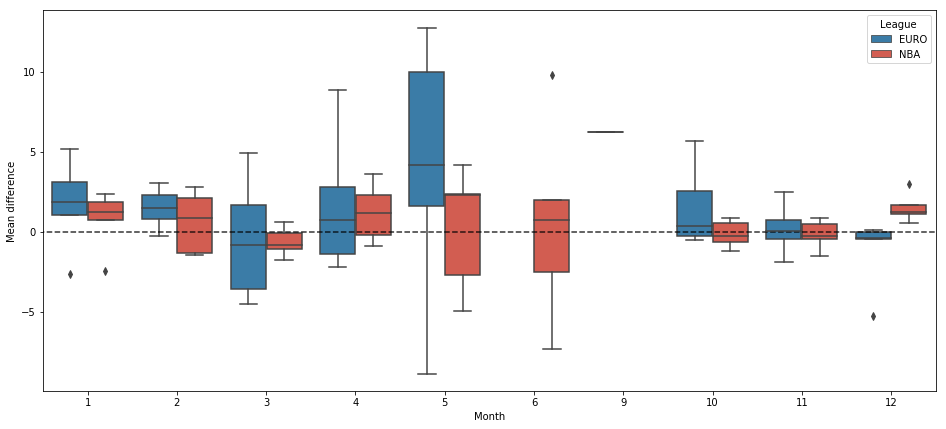

In [241]:
# plot results
f, ax1 = plt.subplots(figsize=(16,7))

# exclude semptember because of low amout of data
sns.boxplot(x="Month", y="Mean difference", hue="League", data=_df, ax=ax1, palette=["#2980b9", "#e74c3c"])
ax1.plot([-1, 13], [0, 0], "k--", alpha=0.8);

### Check whatever number of matches per month distors statistics
In Euroleague only 9 matches on average are player. For this reason I excluded them from anlysis

In [249]:
_df = df.set_index("Date")
# Create new DataFrame
_df = pd.DataFrame({"Matches": _df.groupby([pd.Grouper(freq='M'), "League", "Season"])["OU"].count()}).reset_index()
# add new month column
_df["Month"] = _df["Date"].dt.month
# _df.groupby(["Month", "League", "Season"])["Matches"].mean()

In [247]:
_df[_df.Month==9]

,Date,League,Season,Matches,Month
17,2014-09-30,EURO,2014/2015,7,9


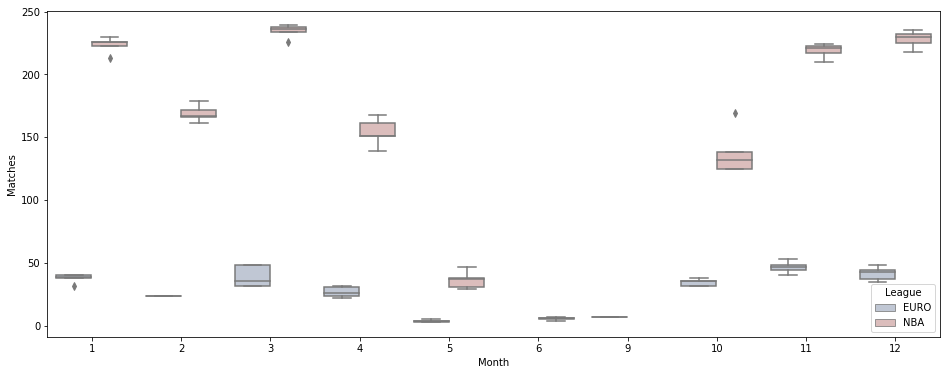

In [202]:
plt.figure(figsize=(16, 6))
sns.boxplot(x="Month", y="Matches", hue="League", data=_df, palette="vlag", dodge=True);

In [183]:
_df = df.set_index("Date")
# _df.groupby([pd.Grouper(freq='M'), "League", "Season"])[["OU","Total"]].mean().head()
# _df.groupby([pd.Grouper(freq='M'), "League", "Season"])["OU"].mean() - _df.groupby([pd.Grouper(freq='M'), "League", "Season"])["Total"].mean()
_df = pd.DataFrame({"Mean difference": _df.groupby([pd.Grouper(freq='M'), "League", "Season"])["OU"].mean() - _df.groupby([pd.Grouper(freq='M'), "League", "Season"])["Total"].mean()}).reset_index()
_df.head()

# _df = pd.DataFrame({"Mean OU": _df.groupby([pd.Grouper(freq='M'), "League", "Season"])["OU"].mean(),
#                     "Mean Total": _df.groupby([pd.Grouper(freq='M'), "League", "Season"])["Total"].mean()}).reset_index()
# _df.head()

,Date,League,Season,Mean difference
0,2013-10-31,EURO,2013/2014,-2.539474
1,2013-10-31,NBA,2013/2014,0.272000
2,2013-11-30,EURO,2013/2014,1.896226
3,2013-11-30,NBA,2013/2014,0.253363
4,2013-12-31,EURO,2013/2014,-0.014286


In [186]:
# _df_nba = _df[_df["League"] == "NBA"].copy()
# _df_nba["Month"] = _df_nba["Date"].dt.month
_df["Month"] = _df["Date"].dt.month
_df.head()

,Date,League,Season,Mean difference,Month
0,2013-10-31,EURO,2013/2014,-2.539474,10
1,2013-10-31,NBA,2013/2014,0.272000,10
2,2013-11-30,EURO,2013/2014,1.896226,11
3,2013-11-30,NBA,2013/2014,0.253363,11
4,2013-12-31,EURO,2013/2014,-0.014286,12


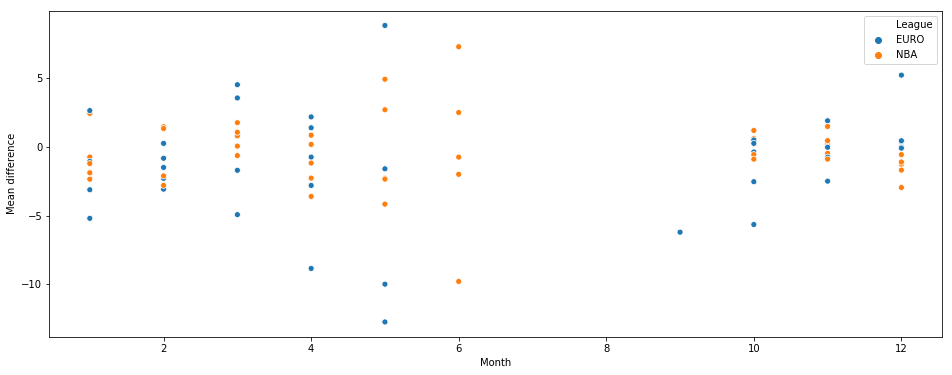

In [187]:
plt.figure(figsize=(16, 6))
sns.scatterplot(x="Month", y="Mean difference", hue="League", data=_df)
plt.plot([])

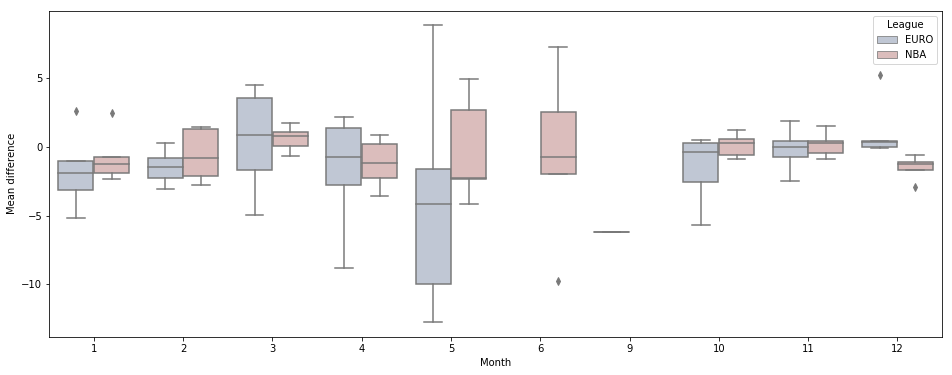

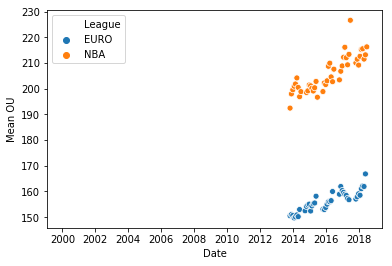

In [152]:
sns.scatterplot(x="Date", y="Mean OU", hue="League", data=_df)

In [ ]:
DataFrame({'count' : df1.groupby( [ "Name", "City"] ).size()}).reset_index()

In [126]:
df[df.OU>250]["OU"]>df[df.OU>250]["Total"]

1809    False
3218    False
4712    False
4713    False
6080    False
6081     True
7387     True
7388     True
dtype: bool

### 3.1.1 Analyze Over/Under markets 

In [ ]:
df_nba.columns

In [ ]:
df.OU.hist()

In [ ]:
sns.distplot(df.OU.values, label="Overs")
sns.distplot(df.Total.values, label="Totals")
plt.legend();

In [ ]:
df.Total.hist()

In [ ]:
df_nba.OU.dtype

In [ ]:
data=df[df.OU>100]
# data.groupby(["League", "Season"])["URL"].count()
# data.OU.hist()
print(data.iloc[0]["URL"])
print(data.iloc[0]["OU"])

In [ ]:
data=df[df.OU>270]
for _ in data.URL:
    print(_)

In [ ]:
g = sns.FacetGrid(df, row="Season", col="League", hue="OT", margin_titles=True, height=5)
g.map(plt.scatter, "Total", "OU");

### Calculate implied propabilities and absolute difference between propabilities
* Implied propability is inverse of european coefficient.
* Create separate DataFrames or each league.

In [ ]:
df["Home_prop"] = 1/df["Home_p"]
df["Away_prop"] = 1/df["Away_p"]
df["Diff_prop"] = abs(df["Home_prop"] - df["Away_prop"])
df.head()

## Compare League competiveness

In [ ]:
# Absolute difference between home and away team win propabilities
df.groupby(["League", "Season"])["Diff_prop"].mean()

In [ ]:
# create separate DataFrames for NBA and Euroleague
df_euro = df[df.League == 'EURO']
df_nba = df[df.League == 'NBA']
# get mean difference between propabilities
diff_euro = df_euro.groupby(['Season'])['Diff_prop'].mean()
diff_nba = df_nba.groupby(['Season'])['Diff_prop'].mean()
# plot results
plt.figure(figsize=(16,6))
plt.tick_params(axis='both', which='major', labelsize=16)
plt.plot(diff_euro.index, diff_euro.values, "o-", color="#2980b9", label="Euroleague")
plt.plot(diff_euro.index, diff_nba.values, "o-", color="#e74c3c", label="NBA")
plt.xlabel("Season", fontsize=18)
# plt.yticks([0.38, 0.4, 0.42, 0.44])
plt.ylabel("Implied propability difference", fontsize=18)
plt.legend(fontsize=18)
plt.savefig("images/implied_prop.png", dpi=200, format="png")

### How common are over times

In [ ]:
# Total points
df.groupby(["League", "Season"])["OT"].mean()

In [ ]:
# get season names
seasons = df_euro.Season.unique()[::-1]
# get mean difference between propabilities
ot_euro = df_euro.groupby(['Season'])['OT'].mean() * 100
ot_nba = df_nba.groupby(['Season'])['OT'].mean() * 100
# plot results
plt.figure(figsize=(16,6))
plt.tick_params(axis='both', which='major', labelsize=16)
plt.plot(ot_euro.index, ot_euro.values, "o-", color="#2980b9", label="Euroleague")
plt.plot(ot_nba.index, ot_nba.values, "o-", color="#e74c3c", label="NBA")
plt.xlabel("Season", fontsize=18)
# plt.yticks([4, 5, 6, 7])
plt.ylabel("% of games finished after overtime", fontsize=18)
plt.legend(fontsize=18)
plt.savefig("images/ot_games.png", dpi=200, format="png")

## Home court advantage

In [ ]:
df.groupby(["League", "Season"])["Win"].mean()

In [ ]:
# home team wins
home_w_euro = df_euro.groupby(['Season'])['Win'].mean() * 100
home_w_nba = df_nba.groupby(['Season'])['Win'].mean() * 100
# plot results
plt.figure(figsize=(16,6))
plt.tick_params(axis='both', which='major', labelsize=16)
plt.plot(home_w_euro.index, home_w_euro.values, "o-", color="#2980b9", label="Euroleague")
plt.plot(home_w_euro.index, home_w_nba.values, "o-", color="#e74c3c", label="NBA")
plt.xlabel("Season", fontsize=18)
plt.ylabel("% of games won by home team", fontsize=18)
plt.legend(fontsize=16)
plt.savefig("images/home_victories.png", dpi=200, format="png")

## Profitable strategies

In [ ]:
# create new columns indicating whatever home or away team won
df_win = pd.concat([df, pd.get_dummies(df['Win']).rename(columns={0.0:"Away_win", 1.0:"Home_win"})], axis=1)
df_win.head()

### 1. bet only on home team or on away team

In [ ]:
df_win["All_home"] = (df_win.Home_p-1)*df_win.Home_win - df_win.Away_win
df_win.groupby(["League", "Season"])["All_home"].sum() / df_win.groupby(["League", "Season"])["All_home"].count()

In [ ]:
df_win["All_away"] = (df_win.Away_p-1)*df_win.Away_win - df_win.Home_win
df_win.groupby(["League", "Season"])["All_away"].sum() / df_win.groupby(["League", "Season"])["All_away"].count()

In [ ]:
# calculate win precentage of bet only home or only away
df_win_euro = df_win[df_win.League == "EURO"].copy()
df_win_euro_h = df_win_euro.groupby(['Season'])["All_home"].sum() / df_win_euro.groupby(['Season'])["All_home"].count()
df_win_euro_a = df_win_euro.groupby(['Season'])["All_away"].sum() / df_win_euro.groupby(['Season'])["All_away"].count()
df_win_nba = df_win[df_win.League == "NBA"].copy()
df_win_nba_h = df_win_nba.groupby(['Season'])["All_home"].sum() / df_win_nba.groupby(['Season'])["All_home"].count()
df_win_nba_a = df_win_nba.groupby(['Season'])["All_away"].sum() / df_win_nba.groupby(['Season'])["All_away"].count()

# plot results
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(16,8))
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.plot(seasons, df_win_euro_h*100, "^-", color="#2980b9", label="Euroleague (bet only home)")
ax1.plot(seasons, df_win_euro_a*100, "v--", color="#2980b9", label="Euroleague (bet only away)")
ax1.legend(fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.plot(seasons, df_win_nba_h*100, "^-", color="#e74c3c", label="NBA (bet only home)")
ax2.plot(seasons, df_win_nba_a*100, "v--", color="#e74c3c", label="NBA (bet only away)")
ax2.legend(fontsize=16)
ax2.set_xlabel("Season", fontsize=18)
ax2.set_ylabel("ROI (%)", fontsize=18)
ax2.xaxis.set_label_coords(0.5, -0.12)
ax2.yaxis.set_label_coords(-0.05, 1.0)
f.subplots_adjust(hspace=0)
plt.savefig("bet_strat_1.png", dpi=200, format="png")

### 2. bet only on home favourite or home long shot

In [ ]:
# take rows where home coefficient is lower than away teams
df_win_home_fav = df_win[df_win.Home_p < df_win.Away_p]
df_win_home_fav.groupby(["League", "Season"])["All_away"].sum() / df_win.groupby(["League", "Season"])["All_away"].count()

In [ ]:
# take rows where home coefficient is larger than 3.0
df_win_home_long = df_win[df_win.Home_p > 3.0]
df_win_home_long.groupby(["League", "Season"])["All_away"].sum() / df_win.groupby(["League", "Season"])["All_away"].count()

In [ ]:
# calculate win precentage of betting only on home favourite
df_win_euro_f = df_win_home_fav[df_win_home_fav.League == "EURO"].copy()
df_win_euro_h_f = df_win_euro_f.groupby(['Season'])["All_home"].sum() / df_win_euro_f.groupby(['Season'])["All_home"].count()
df_win_euro_l = df_win_home_long[df_win_home_long.League == "EURO"].copy()
df_win_euro_h_l = df_win_euro_l.groupby(['Season'])["All_home"].sum() / df_win_euro_l.groupby(['Season'])["All_home"].count()
# df_win_euro_a = df_win_euro.groupby(['Season'])["All_away"].sum() / df_win_euro.groupby(['Season'])["All_away"].count()
df_win_nba_f = df_win_home_fav[df_win_home_fav.League == "NBA"].copy()
df_win_nba_h_f = df_win_nba_f.groupby(['Season'])["All_home"].sum() / df_win_nba_f.groupby(['Season'])["All_home"].count()
df_win_nba_l = df_win_home_long[df_win_home_long.League == "NBA"].copy()
df_win_nba_h_l = df_win_nba_l.groupby(['Season'])["All_home"].sum() / df_win_nba_l.groupby(['Season'])["All_home"].count()

# plot results
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(16,8))
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.plot(seasons, df_win_euro_h_f*100, "^-", color="#2980b9", label="Euroleague (home favourite)")
ax1.plot(seasons, df_win_euro_h_l*100, "v--", color="#2980b9", label="Euroleague (home long shot)")
ax1.legend(fontsize=16, loc=2)
# ax1.set_ylim(-5,5)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.plot(seasons, df_win_nba_h_f*100, "^-", color="#e74c3c", label="NBA (home favourite)")
ax2.plot(seasons, df_win_nba_h_l*100, "v--", color="#e74c3c", label="NBA (home long shot)")
ax2.legend(fontsize=16)
# ax2.set_ylim(-5,5)
ax2.set_xlabel("Season", fontsize=16)
ax2.set_ylabel("ROI (%)", fontsize=16)
ax2.xaxis.set_label_coords(0.5, -0.12)
ax2.yaxis.set_label_coords(-0.05, 1.0)
f.subplots_adjust(hspace=0)
# plt.savefig("bet_strat_2.png", dpi=200, format="png")